In [2]:
import torch
import numpy as np
import scipy.sparse as sp
import pickle
import pandas as pd
from models import GFM, MLP, NeuCF, Recommender
from matplotlib import pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Functions

In [3]:
def HitRatio(predicted, real, k):
    for item in predicted[:k]:
        if item == real:
            return 1
    return 0


def nDCG(predicted, real, k):
    for i in range(len(predicted[:k])):
        item = predicted[i]
        if item == real:
            return np.log(2) / np.log(i+2)
    return 0

def testing(model, name, data, negative, all_negative, gold_recs):
    print('MODEL:', name)
    hr, ndcg = evaluate(model, negative)
    print(f'Metrics HR: {hr:.2f}, nDCG: {ndcg:.2f}')
    movie_id = 1
    movie = movie_info[movie_info['movie_id'] == movie_id].to_dict('records')[0]
    print(f'SIMILARS for {movie["name"]}')
    items = model.similar_items(movie_id)
    df = pd.DataFrame()
    for item in items:
        df = df.append(movie_info[movie_info['movie_id'] == item])
    print(df.to_string())
    user_id = 4
    print(f'RECOMMENDATIONS for user {user_id}')
    recs = model.recommend(user_id, all_negative)
    df = pd.DataFrame()
    for item in recs:
        df = df.append(movie_info[movie_info['movie_id'] == item])
    print(df.to_string())
#     intersection = set(df['movie_id'].values) & set(gold_recs)
#     print(f'True {len(intersection)}: {intersection}')


def evaluate(model, negative, k=10):
    hrs, ndcgs = [], []
    for u in negative.keys():
        user_vect = np.ones(100) * u
        try:
            pred = model.predict(user_vect, negative[u]).cpu().detach().numpy()
        except AttributeError:
            pred = model.predict(user_vect, negative[u])
        rank = np.array(negative[u])[np.argsort(pred)[::-1]]
        y = negative[u][0]
        hr = HitRatio(rank, y, k)
        ndcg = nDCG(rank, y, k)
        hrs.append(hr)
        ndcgs.append(ndcg)
    return sum(hrs) / len(hrs), np.mean(ndcgs)


def load(name):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
get_user_history = lambda user_id, implicit_ratings : [' '.join(movie_info[movie_info["movie_id"] == x][['movie_id', 'name', 'category']].values[0].astype(str).tolist())
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

# 1. Dataset

Взяла датасет из первой домашки (movielens1m), так как его часто используют, и он небольшой.
В качестве test использовался последний фильм, который посмотрел пользователь.

In [4]:
train = sp.load_npz('data/train_csr.npz')
test = load('test')
negative = load('test_neg')
movie_info = pd.read_csv('data/movies.dat', delimiter='::', header=None,
                         names=['movie_id', 'name', 'category'], engine='python')
ratings = pd.read_csv('data/ratings.dat', delimiter='::', header=None,
                      names=['user_id', 'movie_id', 'rating', 'timestamp'],
                      usecols=['user_id', 'movie_id', 'rating'], engine='python')
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
positive = [train[i].indices for i in range(train.shape[0])]
all_negative = [np.setdiff1d(np.arange(train.shape[1]), pos) for pos in positive]

# Testing

Будем смотреть симилары для Toy Story и рекомендации для пользователя 4

История просмотра для пользователя 4:

In [13]:
get_user_history(4, implicit_ratings)

['3468 Hustler, The (1961) Drama',
 '2951 Fistful of Dollars, A (1964) Action|Western',
 '1214 Alien (1979) Action|Horror|Sci-Fi|Thriller',
 '1036 Die Hard (1988) Action|Thriller',
 '260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Fantasy|Sci-Fi',
 '2028 Saving Private Ryan (1998) Action|Drama|War',
 '480 Jurassic Park (1993) Action|Adventure|Sci-Fi',
 '1198 Raiders of the Lost Ark (1981) Action|Adventure',
 '1954 Rocky (1976) Action|Drama',
 "1097 E.T. the Extra-Terrestrial (1982) Children's|Drama|Fantasy|Sci-Fi",
 '3418 Thelma & Louise (1991) Action|Drama',
 '3702 Mad Max (1979) Action|Sci-Fi',
 '2366 King Kong (1933) Action|Adventure|Horror',
 '1387 Jaws (1975) Action|Horror',
 '1201 Good, The Bad and The Ugly, The (1966) Action|Western',
 '2692 Run Lola Run (Lola rennt) (1998) Action|Crime|Romance',
 '2947 Goldfinger (1964) Action',
 '1240 Terminator, The (1984) Action|Sci-Fi|Thriller']

In [5]:
gold = [3468, 2951, 1214, 1036, 260, 2028, 480, 1198, 1954, 1097, 3418, 3418, 2366, 1387, 1201, 2692, 2947, 1240]

# 2. BPR

In [5]:
bpr_params = {
        'n_components': 64,
        'lr': 1e-3,
        'schedule': 'adagrad',
        'alpha': 1e-3,
        'epochs': 50
    }

In [17]:
from lightfm import LightFM
bpr =  LightFM(loss='bpr',
                  no_components=bpr_params['n_components'],
                  learning_rate=bpr_params['lr'],
                  learning_schedule=bpr_params['schedule'],
                  user_alpha=bpr_params['alpha'],
                  item_alpha=bpr_params['alpha'])

recommender = Recommender(bpr, 'BPR')
print('Fit')
recommender.fit(train, bpr_params, plot=False)
print('Testing')
testing(recommender, 'BPR', train, negative, all_negative, gold)

Fit
Testing
MODEL: BPR
Metrics HR: 0.39, nDCG: 0.27
SIMILARS for Toy Story (1995)
      movie_id                                               name                        category
0            1                                   Toy Story (1995)     Animation|Children's|Comedy
352        356                                Forrest Gump (1994)              Comedy|Romance|War
1936      2005                                Goonies, The (1985)    Adventure|Children's|Fantasy
360        364                              Lion King, The (1994)    Animation|Children's|Musical
363        367                                   Mask, The (1994)            Comedy|Crime|Fantasy
1375      1396                                    Sneakers (1992)              Crime|Drama|Sci-Fi
2647      2716                                Ghostbusters (1984)                   Comedy|Horror
1539      1580                                Men in Black (1997)  Action|Adventure|Comedy|Sci-Fi
1543      1584                      

Симилары хорошие, рекомендации тоже, метрики не очень.

# 3. NCF

* https://arxiv.org/pdf/1708.05031.pdf
* Модели лежат в models.py

In [17]:
def get_data_ncf(data):
    new_data = []
    for i, user in enumerate(data):
        positive = [(i, pos, 1) for pos in user.indices]
        if len(positive) > 0:
            negative = np.setdiff1d(np.arange(data.shape[1]), user.indices)
            negative = np.random.choice(negative, len(positive))
            negative = [(i, neg, 0) for neg in negative]
            result = np.vstack((positive, negative))
            new_data.append(result)
    return np.vstack(new_data)

### GFM

In [10]:
gfm_params = {
        'batch_size': 256,
        'dim': 64,
        'epochs': 50,
        'lr': 5e-3
}

In [11]:
train_data = get_data_ncf(train)

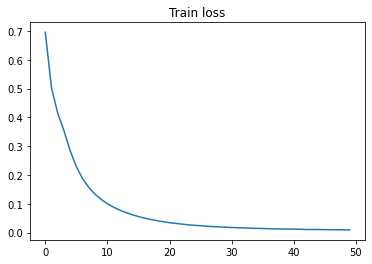

In [12]:
gfm = GFM(max(users) + 1, max(movies) + 1, gfm_params['dim']).to(device)
gfm.load_state_dict((torch.load('models/gfm.pcl', map_location=torch.device('cpu'))))
recommender = Recommender(gfm, 'GFM')
# print('Fit')
# recommender.fit(train_data, gfm_params, plot=True)
df = pd.read_csv('plots/gfm.csv')
plt.plot(df['Step'], df['GFM-3 - loss'])
plt.title('Train loss')
plt.show()

In [13]:
print('Testing')
testing(recommender, 'GFM', train, negative, all_negative, gold)

Testing
MODEL: GFM
Metrics HR: 0.46, nDCG: 0.44
SIMILARS for Toy Story (1995)
      movie_id                                               name                         category
0            1                                   Toy Story (1995)      Animation|Children's|Comedy
3045      3114                                 Toy Story 2 (1999)      Animation|Children's|Comedy
547        551             Nightmare Before Christmas, The (1993)        Children's|Comedy|Musical
1262      1282                                    Fantasia (1940)     Animation|Children's|Musical
1250      1270                          Back to the Future (1985)                    Comedy|Sci-Fi
257        260          Star Wars: Episode IV - A New Hope (1977)  Action|Adventure|Fantasy|Sci-Fi
2647      2716                                Ghostbusters (1984)                    Comedy|Horror
711        720  Wallace & Gromit: The Best of Aardman Animatio...                        Animation
1220      1240                 

Метрики получше, рекомендации похуже чем у BPR

### MLP

In [7]:
mlp_params = {
        'batch_size': 256,
        'dim': 64,
        'epochs': 50,
        'lr': 1e-3, 
        'hidden': [32, 32, 32]
}

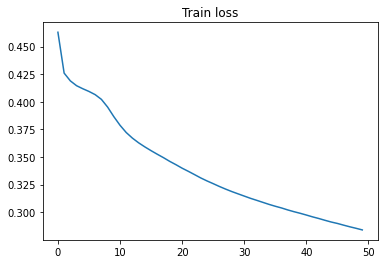

In [8]:
mlp = MLP(max(users) + 1, max(movies) + 1, mlp_params['dim'], 
          hidden_dim=mlp_params['hidden']).to(device)
mlp.load_state_dict((torch.load('models/mlp.pcl', map_location=torch.device('cpu'))))
recommender = Recommender(mlp, 'MLP')
# print('Fit')
# recommender.fit(train_data, mlp_params, plot=True)
df = pd.read_csv('plots/mlp.csv')
plt.plot(df['Step'], df['MLP-2 - loss'])
plt.title('Train loss')
plt.show()

In [9]:
print('Testing')
testing(recommender, 'MLP', train, negative, all_negative, gold)

Testing
MODEL: MLP
Metrics HR: 0.60, nDCG: 0.32
SIMILARS for Toy Story (1995)
      movie_id                                 name                     category
0            1                     Toy Story (1995)  Animation|Children's|Comedy
1239      1259                   Stand by Me (1986)       Adventure|Comedy|Drama
3684      3753                  Patriot, The (2000)             Action|Drama|War
2647      2716                  Ghostbusters (1984)                Comedy|Horror
352        356                  Forrest Gump (1994)           Comedy|Romance|War
1245      1265                 Groundhog Day (1993)               Comedy|Romance
2252      2321                 Pleasantville (1998)                       Comedy
3078      3147               Green Mile, The (1999)               Drama|Thriller
2637      2706                  American Pie (1999)                       Comedy
1854      1923  There's Something About Mary (1998)                       Comedy
RECOMMENDATIONS for user 4
    

nDCG не сильно лучше чем у BPR. Cимилары хуже чем у GFM, но рекомендации лучше.

### NeuCF

In [14]:
neucf_params = {
    'epochs': 50, 
    'lr': 1e-3, 
    'batch_size': 256
}

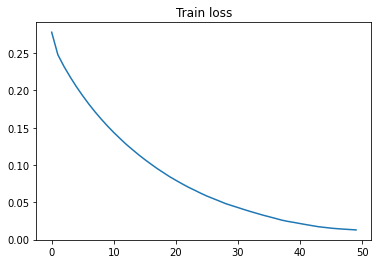

In [15]:
neucf = NeuCF(max(users) + 1, max(movies) + 1, gfm_params['dim'], mlp_params['dim'], 
              mlp_params['hidden'], 'models/gfm.pcl', 'models/mlp.pcl').to(device)
neucf.load_state_dict((torch.load('models/neucf.pcl', map_location=torch.device('cpu'))))
recommender = Recommender(neucf, 'NeuCF')
# print('Fit')
# recommender.fit(train_data, neucf_params, plot=True)
df = pd.read_csv('plots/neucf.csv')
plt.plot(df['Step'], df['NeuCF - loss'])
plt.title('Train loss')
plt.show()

In [16]:
print('Testing')
testing(recommender, 'NeuCF', train, negative, all_negative, gold)

Testing
MODEL: NeuCF
Metrics HR: 0.55, nDCG: 0.47
SIMILARS for Toy Story (1995)
      movie_id                                       name                         category
0            1                           Toy Story (1995)      Animation|Children's|Comedy
2647      2716                        Ghostbusters (1984)                    Comedy|Horror
1250      1270                  Back to the Future (1985)                    Comedy|Sci-Fi
547        551     Nightmare Before Christmas, The (1993)        Children's|Comedy|Musical
257        260  Star Wars: Episode IV - A New Hope (1977)  Action|Adventure|Fantasy|Sci-Fi
1239      1259                         Stand by Me (1986)           Adventure|Comedy|Drama
1593      1639                         Chasing Amy (1997)                    Drama|Romance
3045      3114                         Toy Story 2 (1999)      Animation|Children's|Comedy
2593      2662              War of the Worlds, The (1953)                Action|Sci-Fi|War
476       

По сравнению с BPR у NCF метрики лучше, но рекомендации похуже. 